<a href="https://colab.research.google.com/github/rnagabhyrava/wayfair-competition/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using Data to Bring Customers Home

**The challenge is divided into two tasks**

*   Classification: whether the customer converts in next 30 days or not
*   Regression: Predict the amount of revenue generated for the customer.



## Summary of this notebook


*  There are lot of missing values which needs to be taken care of.
*   Data is imbalanced with only 8% of customers actually converted.
*  Few variables are correlated which may effect the model so needs to be take care of.
*   Revenue has a few outliers which are extreme, may need to take care of these values.

### Next Steps

*  Impute maxnps, minnps, avgnps with mean value (as this is a rating which when imputed zero might effect models)
*  Impute all the remaining as most of these are missing because there is not activity from the customer like the web activity ..
*  Applying balancing techniques to see if it can help
*  Using models which are robust to class weight and/or have a class_weight option.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.figure_factory as ff
import seaborn as sns


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Exploratory data analysis

In [0]:
df=pd.read_csv('drive/My Drive/wayfair/df_training_scholarjet.csv')

###Data Overview

In [0]:
print("Data shape:",df.shape)
df.head()

Data shape: (28126, 183)


,cuid,convert_30,revenue_30,roll_up,currentstatus,companytypegroup,team,customersource,accrole,num_employees,num_purchases_year,cost_purchases_year,enrollmentmethod,numorderone,numorderthreeone,numorderseventhree,numorderthirtyseven,numordersixtythirty,numorderyearsixty,sumrevone,sumrevthreeone,sumrevseventhree,sumrevthirtyseven,sumrevsixtythirty,sumrevyearsixty,numbamorder,numselforder,totalrev,aov,dayssincelastord,cuidshare,numstores,pospercentage,numinf,numinfconnect,numinfphone,numinfquote,percentlarge,percdirtythirty,percdirtyninetythirty,...,numtasksothersixtythirty,numtasksotheryearsixty,numcallsone,numcallsthreeone,numcallsseventhree,numcallsthirtyseven,numcallssixtythirty,numcallsyearsixty,numemailsone,numemailsthreeone,numemailsseventhree,numemailsthirtyseven,numemailssixtythirty,numemailsyearsixty,totalcalldurationone,totalcalldurationthreeone,totalcalldurationseventhree,totalcalldurationthirtyseven,totalcalldurationsixtythirty,totalcalldurationyearsixty,decmakerflagone,decmakerflagsevenone,decmakerflagfourteenseven,decmakerflagthirtyfourteen,percsecondsinbound,percemailopenedone,percemailopenedthreeone,percemailopenedseventhree,percemailopenedthirtyseven,percemailopenedsixtythirty,percemailopenedyearsixty,percemailclickedone,percemailclickedthreeone,percemailclickedseventhree,percemailclickedthirtyseven,percemailclickedsixtythirty,percemailclickedyearsixty,currentapplicability,numemaillist,dayssinceenrollment
0,20,0,0.0,Onboarding,Active,Business,US,External Application,None,50plus,1to2,lessthan1,directEIN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,59.99,0.0,0.00,0.0,1.0,59.99,59.99,17,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.00,0.80,0.809524,0.000000,0.000000,0.0,0.0,0.0,0.190476,0.000000,0.000000,3.000000,1.0,17
1,57,0,0.0,Onboarding,Active,Business,US,Internal Application,None,2to5,25plus,25to100,directEIN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,126.48,0.0,1.0,126.48,126.48,62,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,55.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.080000,0.000000,0.020000,0.0,0.0,0.0,0.040000,0.000000,0.020000,3.000000,1.0,70
2,163,0,0.0,Onboarding,Active,Business,US,Internal Application,None,1,3to5,1to5,directEIN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,237.98,0.0,0.00,0.0,1.0,237.98,237.98,27,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.00,0.113636,0.086207,0.106195,0.0,0.0,0.0,0.000000,0.000000,0.001770,13.000000,1.0,27
3,167,0,0.0,Onboarding,Enrolled,Business,US,Internal Customer Scrape,None,50plus,3to5,lessthan1,directEIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,67.0,0.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,1.000000,0.000000,0.100000,0.0,0.0,0.0,0.000000,0.000000,0.100000,NaN,NaN,25
4,168,0,0.0,Onboarding,Enrolled,Business,US,Gateway,None,6to10,11to25,5to25,directEIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.05,0.047619,0.058824,0.072072,0.0,0.0,0.0,0.009524,0.016807,0.003465,8.333333,3.0,33


There are around 180 variables! It's clear that some of them are categorical, some look numeric. Some numeric features are integer typed. And others are of float type but from the first few rows they look like integer typed too, since fractional part is zero, but pandas treats them as float since there are NaN values in that features.

We also see some NaN in some columns lets look a bit deep into this.

In [0]:
# Number of NaNs for each object
df.isnull().sum(axis=1).head(15)

0      19
1      20
2      19
3      49
4      47
5     101
6      46
7      15
8      17
9      44
10     52
11     65
12     47
13     16
14     45
dtype: int64

**From initial inspection there are a lot of missing values**

In [0]:
# Number of NaNs for each column
print("Total number of missing values:", df.isnull().sum().sum())
df.isnull().sum(axis=0)

Total number of missing values: 1330168


cuid                                0
convert_30                          0
revenue_30                          0
roll_up                             0
currentstatus                       0
companytypegroup                    0
team                                0
customersource                      0
accrole                             0
num_employees                       0
num_purchases_year                  0
cost_purchases_year                 0
enrollmentmethod                    0
numorderone                     18424
numorderthreeone                18424
numorderseventhree              18424
numorderthirtyseven             18424
numordersixtythirty             18424
numorderyearsixty               18424
sumrevone                       18424
sumrevthreeone                  18424
sumrevseventhree                18424
sumrevthirtyseven               18426
sumrevsixtythirty               18425
sumrevyearsixty                 18426
numbamorder                     18424
numselforder

**Just by reviewing these we see patterns, that certain feature groups are missing a particular number of values.**

### Data Cleaning

**Checking for constant features**

In [0]:
# `dropna = False` makes nunique treat NaNs as a distinct value
feats_counts = df.nunique(dropna = False)
feats_counts.sort_values()

decmakerflagthirtyfourteen          2
convert_30                          2
numtasksotherone                    2
numtasksotherthreeone               2
decmakerflagsevenone                2
companytypegroup                    2
team                                2
numtasksotheryearsixty              2
decmakerflagfourteenseven           2
numtasksreassignone                 2
numtasksothersixtythirty            2
numtasksotherthirtyseven            2
decmakerflagone                     2
numtasksotherseventhree             2
numtaskscadenceseventhree           3
numtasksreassignthirtyseven         3
numtasksreassignsixtythirty         3
numtaskscustactthreeone             3
numtaskscadenceone                  3
numtasksreassignyearsixty           3
numtaskscustactone                  3
numtasksreassignseventhree          3
numtasksreassignthreeone            3
roll_up                             3
accrole                             4
numtaskscadencethreeone             4
numtaskscust

We didn't find any constant features. So let's proceed.

###Determine types

Let's examine the number of unique values and build a histogram of those values

In [0]:
nunique = df.nunique(dropna=False)
nunique

cuid                            28126
convert_30                          2
revenue_30                       2549
roll_up                             3
currentstatus                       4
companytypegroup                    2
team                                2
customersource                     16
accrole                             4
num_employees                       6
num_purchases_year                  6
cost_purchases_year                 6
enrollmentmethod                    6
numorderone                         5
numorderthreeone                    6
numorderseventhree                  7
numorderthirtyseven                11
numordersixtythirty                15
numorderyearsixty                  29
sumrevone                         209
sumrevthreeone                    332
sumrevseventhree                  657
sumrevthirtyseven                2106
sumrevsixtythirty                2034
sumrevyearsixty                  5577
numbamorder                        13
numselforder

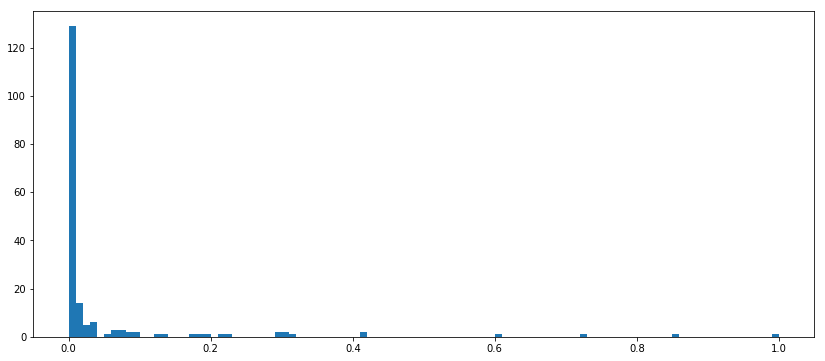

In [0]:
plt.figure(figsize=(14,6))
_ = plt.hist(nunique.astype(float)/df.shape[0], bins=100)

Let's take a looks at the features with a huge number of unique values:

In [0]:
mask = (nunique.astype(float)/df.shape[0] > 0.8)
df.loc[:10, mask]

,cuid,avgprice
0,20,179.926389
1,57,509.668537
2,163,694.247105
3,167,158.152857
4,168,93.175714
5,215,394.651071
6,285,558.136139
7,363,325.937009
8,401,451.654255
9,421,436.544171


Let's look at another pack of features. which have more nonunique values

In [0]:
mask = (nunique.astype(float)/df.shape[0] < 0.8) & (nunique.astype(float)/df.shape[0] > 0.4)
df.loc[:10, mask]

,numsecondsonsiteyearsixty,avgpricethirtyseven,avgpricesixtythirty,avgpriceyearsixty
0,3333.0,80.997273,NaN,335.386429
1,28316.0,235.996667,NaN,537.131333
2,12162.0,144.990000,NaN,709.091892
3,9832.0,52.828333,NaN,206.575000
4,13053.0,64.990000,58.020000,98.647778
5,21847.0,NaN,NaN,398.499455
6,29198.0,580.705135,220.990000,550.232857
7,650279.0,440.500000,116.831330,361.237450
8,5162.0,846.574286,286.595588,317.361154
9,7060.0,408.538772,503.187586,109.629600


**We have float variables, count variables and class variables**

In [0]:
cat_cols = list(df.select_dtypes(include=['object']).columns)
num_cols = list(df.select_dtypes(exclude=['object']).columns)

### Go through

Let's replace NaNs with something first.

In [0]:
df.replace('NaN', -99, inplace=True)

**Let's calculate how many times one feature is greater than the other and create cross tabel out of it.**


In [0]:
df.loc[:,cat_cols].head().T

,0,1,2,3,4
roll_up,Onboarding,Onboarding,Onboarding,Onboarding,Onboarding
currentstatus,Active,Active,Active,Enrolled,Enrolled
companytypegroup,Business,Business,Business,Business,Business
team,US,US,US,US,US
customersource,External Application,Internal Application,Internal Application,Internal Customer Scrape,Gateway
accrole,None,None,None,None,None
num_employees,50plus,2to5,1,50plus,6to10
num_purchases_year,1to2,25plus,3to5,3to5,11to25
cost_purchases_year,lessthan1,25to100,1to5,lessthan1,5to25
enrollmentmethod,directEIN,directEIN,directEIN,directEIN,directEIN


### Correlation

Let's look at correlation of each feature group variables with target columns

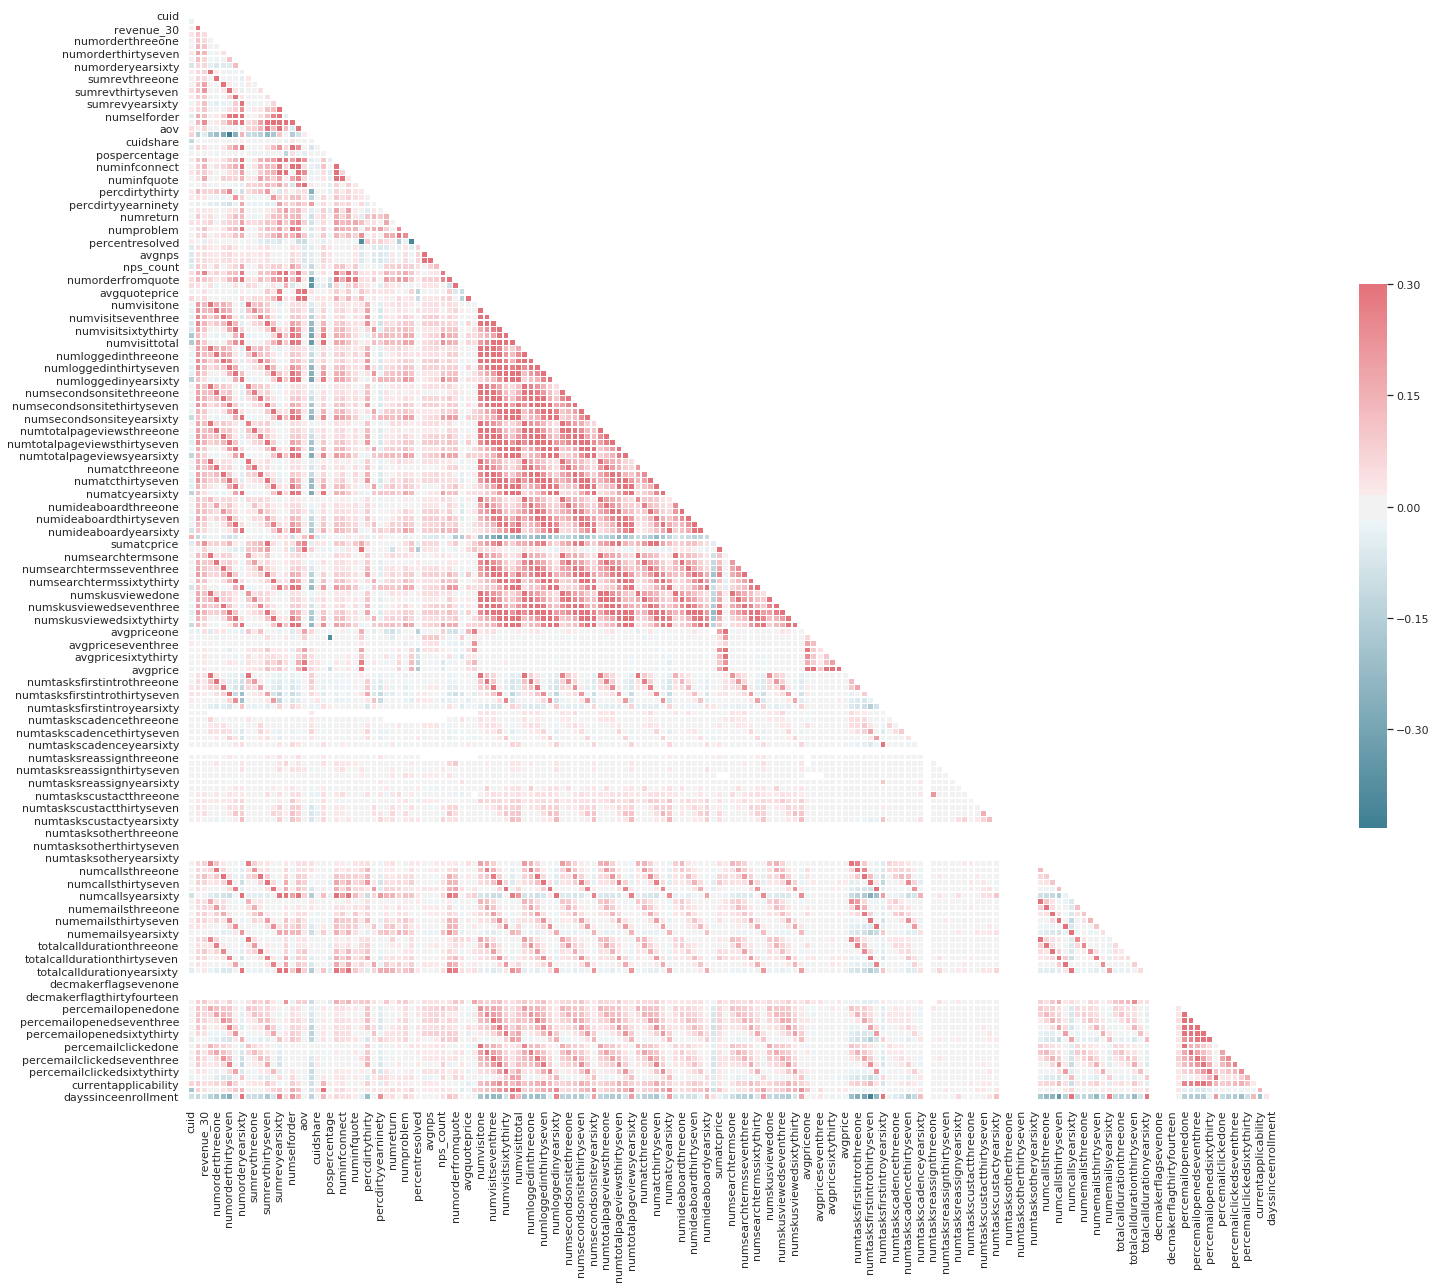

In [0]:
sns.set(style="white")
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(30, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


**We don't get to know much from this plot. Let's see how varibales are correlated with target variables.**

In [0]:
matrix = df.corr().abs().unstack().sort_values().drop_duplicates()
print("Top correlations with Convert_30")
print(pd.DataFrame(matrix['convert_30'].sort_values(ascending=False)).head())
print("\nTop correlations with revenue_30")
print(pd.DataFrame(matrix['revenue_30'].sort_values(ascending=False)).head())

Top correlations with Convert_30
                                     0
numtotalpageviewsthirtyseven  0.228277
numsecondsonsitethirtyseven   0.215480
numloggedinthreeone           0.213733
numsecondsonsiteseventhree    0.196995
numskusviewedseventhree       0.196535

Top correlations with revenue_30
                                    0
convert_30                   0.432595
numquote                     0.256561
sumrevthirtyseven            0.214494
numinfquote                  0.165699
numsecondsonsitethirtyseven  0.148705


We see that some variables are correlated with target variables but not strong.

### Exploring Target variables

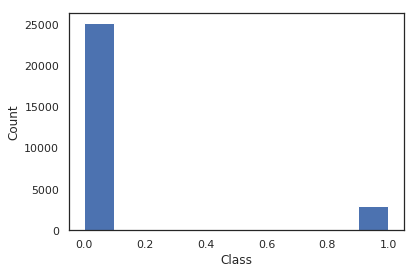

In [0]:
#Convert_30
plt.hist(df.convert_30)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


Clearly, classes are imbalanced. We may need to consider balancing the data in further steps

###Distplot for revenue_30

We dont see much here because most of the cases didn't convert so 0 revenue.

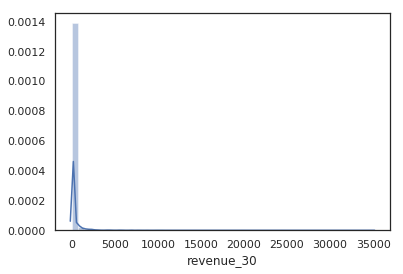

In [0]:
ax = sns.distplot(df.revenue_30)

Let's see the distplot where revenue_30 is greater than 0

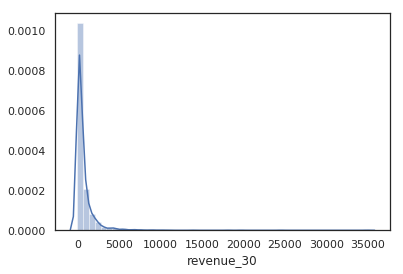

In [0]:
ax = sns.distplot(df.revenue_30[df.revenue_30>0])

The above plot shows that most of the values are less than 5000. Let's look at summary to get a better understanding.

In [0]:
print(df.revenue_30[df.revenue_30>0].describe())
print("90%:",df.revenue_30[df.revenue_30>0].quantile(.9))
print("95%:",df.revenue_30[df.revenue_30>0].quantile(.95))
print("99%:",df.revenue_30[df.revenue_30>0].quantile(.99))

count     2928.000000
mean       720.815176
std       1422.178476
min          4.930000
25%        143.987500
50%        309.005000
75%        764.997500
max      34986.689900
Name: revenue_30, dtype: float64
90%: 1678.4480000000003
95%: 2483.387975000003
99%: 5884.109657000001


We have 30 values greater than *99percentile* these may affect the model. We may need to consider dealing with these values.

In [0]:
df.revenue_30[df.revenue_30>5884.109657000001].shape

(30,)

# Summary


*  There are lot of missing values which needs to be taken care of.
*   Data is imbalanced with only 8% of customers actually converted.
*   Revenue has a few outliers which are extreme, may need to take care of these values.

### Next Steps

*  Impute maxnps, minnps, avgnps with mean value (as this is a rating which when imputed zero might effect models)
*  Impute all the remaining as most of these are missing because there is not activity from the customer like the web activity ..
*  Applying balancing techniques to see if it can help
*  Using models which are robust to class weight and/or have a class_weight option.
